In [1]:
#import the most used things
print("importing...")
import deepchem as dc
import pandas as pd
import numpy as np

importing...


No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!


Error: Unable to import pysam. Please make sure it is installed.
Error: Unable to import pysam. Please make sure it is installed.
Error: Unable to import pysam. Please make sure it is installed.

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (c:\Users\wanne\AppData\Local\Programs\Python\Python310\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (c:\Users\wanne\AppData\Local\Programs\Python\Python310\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [25]:
#first load and featurize all data (I am aware that this is not optimal)
print("colecting data...")
tasks, data, transformers = dc.molnet.load_hopv(featurizer=dc.feat.RDKitDescriptors(), splitter = None)
print("data loaded")

colecting data...


In [27]:
#convert the dataset so that no more nan is present and selct the y-values of the homo gap toghether with the according wheigths

#converting the data set
X = np.nan_to_num(data[0].X, copy=True, nan=0.0)
Y = data[0].y[:,[0]]
w = data[0].w[:,[0]]

#add the cenverted data to new dataframe
new_data= dc.data.DiskDataset.from_numpy(X=X, y=Y, w=w, ids=data[0].ids, tasks = ["HOMO"])

In [45]:
#split the data in train, test and valid samples so that train and test only contains 50% of the values.
print("length of OG dataset: ", len(new_data.X))

splitter = dc.splits.RandomSplitter()
new_dataset, Other_dataset = splitter.train_test_split(new_data,frac_train=0.5)
print("length of th frcation chosen: ", len(new_dataset.X))
train_dataset, test_dataset = splitter.train_test_split(new_dataset)
print("length of the training set: ",len(train_dataset))


length of OG dataset:  350
length of th frcation chosen:  175
length of the training set:  140


In [36]:
# create the GPR model & fit the model
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic, RBF


kernel = 1 * RationalQuadratic()
model = dc.models.SklearnModel(GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100))

print("fitting model...")
model.fit(train_dataset)
print("model is fitted!")

#predict the test set
predicted = model.predict(test_dataset)

fitting model...
model is fitted!


In [37]:
#calculate r2 score
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print('Training set score:', model.evaluate(train_dataset, metric))
test_score= model.evaluate(test_dataset, metric)
print('Test set score:',test_score )

Training set score: {'pearson_r2_score': 1.0}
Test set score: {'pearson_r2_score': 0.19229171993233973}


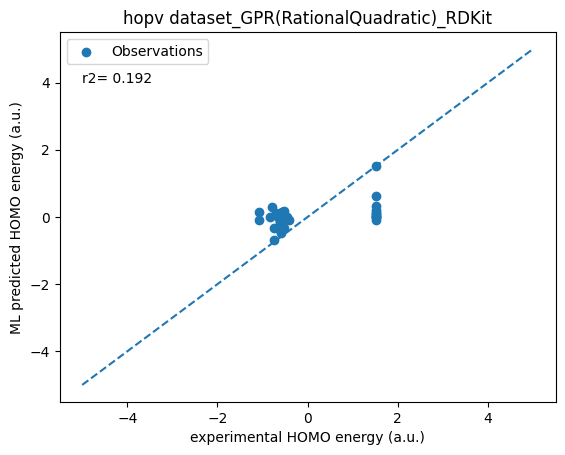

In [38]:
#convert tekst to string, so it can be depicted in matplotlib
number=list(test_score.values())[0]
text = "r2= "+ str(round(number,3))


#plot the data
import matplotlib.pyplot as plt

x=[-5,5]
y=[-5,5]
plt.plot(x, y, linestyle="dashed")
plt.scatter(test_dataset.y, predicted, label="Observations")
plt.legend()
plt.xlabel("experimental HOMO energy (a.u.)")
plt.ylabel("ML predicted HOMO energy (a.u.)")
plt.title("hopv dataset_GPR(RationalQuadratic)_RDKit")
plt.text(-5,4,text)
plt.show()